In [1]:
import ROOT
import numpy as np

import matplotlib.pyplot as plt
import os

Welcome to JupyROOT 6.24/02


In [2]:
%jsroot on

c1 = ROOT.TCanvas("c1", "", 600, 1600);

c1.Divide(2,1)


import uproot

file = ROOT.TFile('../misc/data_stream.root')

file.ls()


file.Get('f_RISE').GetParameter(1), file.Get('f_RISE').GetParError(1)

file.Get('f_FALL').GetParameter(1), file.Get('f_FALL').GetParError(1)

['red', 'cyan', 'green', 'black']

['red', 'cyan', 'green', 'black']

TFile**		../misc/data_stream.root	
 TFile*		../misc/data_stream.root	
  KEY: TGraphErrors	;4	 [current cycle]
  KEY: TGraphErrors	;3	;Delay [ms];Distance [m] [backup cycle]
  KEY: TGraphErrors	;2	;Delay [ms];Distance + bias [m] [backup cycle]
  KEY: TGraphErrors	;1	 [backup cycle]
  KEY: TF1	f_RISE;1	[0]+[1]*x
  KEY: TF1	f_FALL;1	[0]+[1]*x
  KEY: TCanvas	c1;1	
  KEY: TF1	u_ag_f;1	[0]+x*[1]
  KEY: TF1	d_ag_f;1	[0]+x*[1]


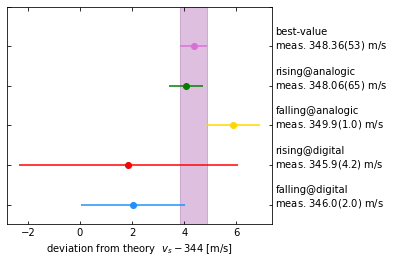

In [14]:
from uncertainties import ufloat
from matplotlib.patches import Rectangle


fig, ax = plt.subplots(figsize=(7,4))

ax.set_yticklabels([])
ax.tick_params(direction='in', bottom=True, top=True, left=True, right=True)
ax.set_xlabel('deviation from theory  $v_s - 344$ [m/s]')

var = ['f_FALL', 'f_RISE', 'd_ag_f', 'u_ag_f']
annotations = ['falling@digital',
               'rising@digital',
               'falling@analogic',
               'rising@analogic']

colors = ['dodgerblue', 'red', 'gold', 'green']

def plot_result(var='', annotation='', color='', index=0, axtmp=None):
    value = ufloat(file.Get(var).GetParameter(1), file.Get(var).GetParError(1))*1000
    sspeed_diff = file.Get(var).GetParameter(1)*1000-344
    sspeed_err=file.Get(var).GetParError(1)*1000
    axtmp.errorbar(x=sspeed_diff, y=index+1, xerr=sspeed_err, fmt='o', color=color, label=var)
    axtmp.annotate((annotation + '\nmeas. ${:.2uSL}$ m/s').format(value), (7.5, 1+index-0.05), annotation_clip=False)
    
    
def get_bestvalue(v1, v2, ev1, ev2):
    return (v1/ev1**2 + v2/ev2**2)/(1/ev1**2 + 1/ev2**2)

def get_bestvalueerr(ev1, ev2):
    return np.sqrt(1/(1/ev1**2 + 1/ev2**2))

sspeed_bestval = get_bestvalue(get_bestvalue(file.Get('f_RISE').GetParameter(1), file.Get('f_FALL').GetParameter(1), 
                                             file.Get('f_RISE').GetParError(1), file.Get('f_FALL').GetParError(1)),
                               get_bestvalue(file.Get('d_ag_f').GetParameter(1), file.Get('u_ag_f').GetParameter(1), 
                                             file.Get('d_ag_f').GetParError(1), file.Get('u_ag_f').GetParError(1)),
                               get_bestvalueerr(file.Get('f_RISE').GetParError(1), file.Get('f_FALL').GetParError(1)),
                               get_bestvalueerr(file.Get('d_ag_f').GetParError(1), file.Get('u_ag_f').GetParError(1)))*1000-344
sspeed_bestvalerr = get_bestvalueerr(get_bestvalueerr(file.Get('f_RISE').GetParError(1), file.Get('f_FALL').GetParError(1)),
                                     get_bestvalueerr(file.Get('d_ag_f').GetParError(1), file.Get('u_ag_f').GetParError(1)))*1000


for i in range(len(var)):
    plot_result(var=var[i], annotation=annotations[i], color=colors[i], index=i, axtmp=ax)
  
value = ufloat(sspeed_bestval+344, sspeed_bestvalerr)
ax.errorbar(x=sspeed_bestval, y=len(var)+1, xerr=sspeed_bestvalerr, fmt='o', color='orchid', label='best')
ax.annotate(('best-value' + '\nmeas. ${:.2uSL}$ m/s').format(value), (7.5, 1+4-0.05), annotation_clip=False)

ax.add_patch(Rectangle((sspeed_bestval-sspeed_bestvalerr, 0), sspeed_bestvalerr*2,len(var)+1+1+1, color='purple', alpha=0.25))

ax.set_ybound(0.5,len(var)+1+1)
fig.subplots_adjust(right=0.65)

plt.show()

fig.savefig('fig.pdf')